In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import torch
from tqdm import tqdm
import torchdiffeq
import pygot
import pandas as pd
import seaborn as sns
from pygot.external import TIGON_interface
from help_function import cell_fate_helper as hf
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
%matplotlib inline

In [2]:
import random
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
 
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True


## Loading Data

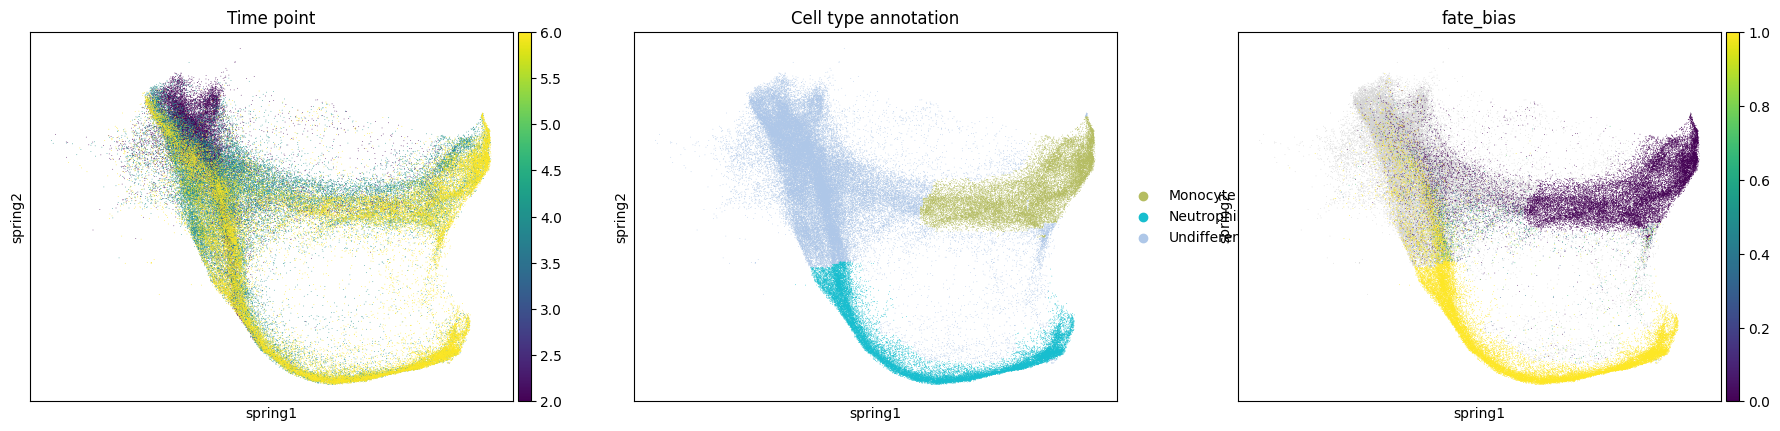

In [3]:
adata = sc.read_h5ad('../pygot_data/03_cellfate/adata_hpsc.h5ad')

time_key = 'Time point'
cell_type_key = 'Cell type annotation'
embedding_key = 'X_pca'
sc.pl.embedding(adata,basis='spring',color=[time_key, cell_type_key, 'fate_bias'])
X_pca = adata.obsm[embedding_key] 
dim = 10
adata.obsm[embedding_key] = adata.obsm[embedding_key][:,:dim]
adata.varm['PCs'][:, :dim]
adata = adata[adata.obs.sort_values(time_key).index]

ts = np.sort(np.unique(adata.obs[time_key]))
ts_map = dict(zip(ts, range(len(ts))))
adata.obs['time_label'] = adata.obs[time_key].replace(ts_map)
adata.obsm['X_spring'] = adata.obsm['X_spring'] / 500


embedding_key = 'X_pca'
velocity_key = 'velocity_pca'
time_key = 'time_label' 

In [82]:
fig, axes = plt.subplots(1,2, figsize=(6.4*2, 4.8))
sc.pl.embedding(adata, color=[time_key], basis='spring', ax=axes[0], colorbar_loc=None, frameon=False, show=False, title=[''], legend_loc=None)
sc.pl.embedding(adata, color=[cell_type_key], basis='spring', ax=axes[1], colorbar_loc=None, frameon=False, show=False, title=[''], legend_loc=None)
plt.savefig('/disk/share/xuruihong/pygot_fig/benchmark_cell_fate_hpsc_data.jpg', format='jpg', dpi=1000)

## Compute Grond Truth based on Clone Information

In [4]:
from scipy.sparse import csr_matrix
clone_key = 'clone'
clone_library = adata.obs[clone_key][~np.isnan(adata.obs[clone_key])].unique()
X_clone = np.zeros(shape=(len(adata), len(clone_library)))
for i in range(len(clone_library)):
    X_clone[np.where(adata.obs[clone_key] == clone_library[i])[0], i] = 1
X_clone = csr_matrix(X_clone)
adata.obsm['X_clone'] = X_clone

In [5]:
adata.obs['time_info'] = adata.obs[time_key]
adata.obs['state_info'] = adata.obs[cell_type_key]
adata.obsm['X_emb'] = adata.obsm['X_spring']

Infer transition map between neighboring time points.
--> Clonal cell fraction (day 0.0-1.0): 0.07878156471697177
--> Clonal cell fraction (day 1.0-2.0): 0.22397881600335587
--> Clonal cell fraction (day 1.0-0.0): 0.11234334853966756
--> Clonal cell fraction (day 2.0-1.0): 0.45161798697205296
--> Numer of cells that are clonally related -- day 0.0: 1588  and day 1.0: 4285
--> Numer of cells that are clonally related -- day 1.0: 8543  and day 2.0: 17194
Number of multi-time clones post selection: 2625
Cell number=96371, Clone number=2625
--> clonal_cell_id_t1: 10131
--> Tmap_cell_id_t1: 58299
Use all clones (naive method)
Use all clones (naive method)


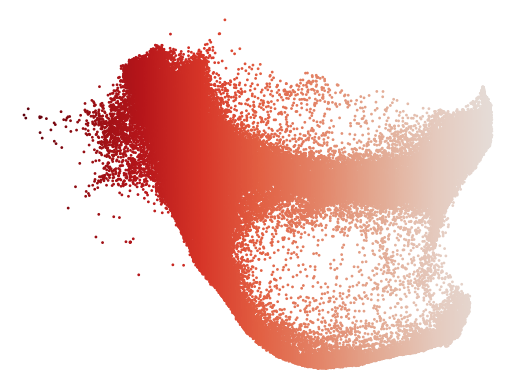

In [6]:
import cospar as cs
adata_processed = cs.tmap.infer_Tmap_from_clonal_info_alone(
    adata,
)

In [7]:
cs.tl.fate_map(
    adata_processed,
    selected_fates=["Neutrophil", "Monocyte"],
    source="clonal_transition_map",
    map_backward=True,
)

adata_processed.obs['Cospar_fate_bias'] = adata_processed.obs['fate_map_clonal_transition_map_Neutrophil'] / (adata_processed.obs['fate_map_clonal_transition_map_Neutrophil'] + adata_processed.obs['fate_map_clonal_transition_map_Monocyte'])

Results saved at adata.obs['fate_map_clonal_transition_map_Neutrophil']
Results saved at adata.obs['fate_map_clonal_transition_map_Monocyte']


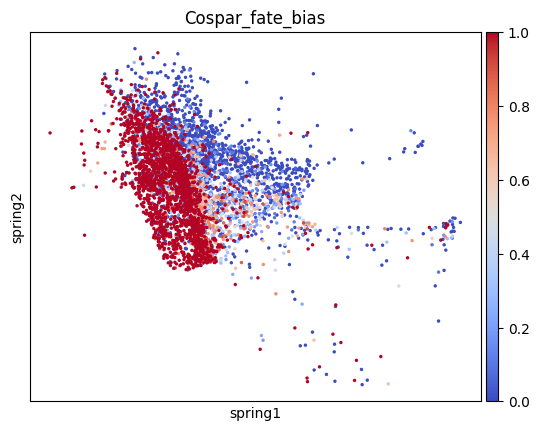

In [8]:
x0_adata = adata_processed[  (adata_processed.obs[cell_type_key] == 'Undifferentiated') & (~np.isnan(adata_processed.obs['Cospar_fate_bias']))].copy()
groundtruth_key = 'Cospar_fate_bias'
sc.pl.embedding(x0_adata, color='Cospar_fate_bias', basis='spring',cmap='coolwarm')

# Training model

### GOT

In [25]:
gots = []
pred_bias_gots = []
for i in range(10):
    
    model, _ = pygot.tl.traj.fit_velocity_model(adata, time_key=time_key, embedding_key=embedding_key, path='../pygot_data/03_cellfate/hpsc/k50/', 
                                       device=device,  v_centric_batch_size=512, x_centric_batch_size=512, x_centric_iter_n=5000,  time_varying=True, 
                                                landmarks=True)
    gots.append(model)
    

loading saved shortest path profile


loss :15.2746  best :15.0420: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:14<00:00, 19.64it/s]


loading saved shortest path profile


loss :15.2594  best :15.1714: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:15<00:00, 19.58it/s]


loading saved shortest path profile


loss :15.1174  best :15.1134: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:14<00:00, 19.62it/s]


loading saved shortest path profile


loss :15.2171  best :15.0855: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:21<00:00, 19.12it/s]


loading saved shortest path profile


loss :15.1912  best :15.1234: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:13<00:00, 19.70it/s]


loading saved shortest path profile


loss :15.2739  best :15.2102: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:12<00:00, 19.79it/s]


loading saved shortest path profile


loss :15.2335  best :15.1358: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:19<00:00, 19.25it/s]


loading saved shortest path profile


loss :15.4884  best :15.3195: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:24<00:00, 18.90it/s]


loading saved shortest path profile


loss :15.4172  best :15.1931: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:24<00:00, 18.91it/s]


loading saved shortest path profile


loss :15.0155  best :15.0155: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:18<00:00, 19.37it/s]


In [226]:
for i, got in enumerate(gots):
    os.system('mkdir ./benchmark_model/GOT/03_cell_fate/weinreb_fate/pc10/'+str(i))
    torch.save(got, './benchmark_model/GOT/03_cell_fate/weinreb_fate/pc10/'+str(i)+'/model.pkl')

mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/weinreb_fate/pc10/0’: File exists
mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/weinreb_fate/pc10/1’: File exists
mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/weinreb_fate/pc10/2’: File exists
mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/weinreb_fate/pc10/3’: File exists
mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/weinreb_fate/pc10/4’: File exists
mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/weinreb_fate/pc10/5’: File exists
mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/weinreb_fate/pc10/6’: File exists
mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/weinreb_fate/pc10/7’: File exists
mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/weinreb_fate/pc10/8’: File exists
mkdir: cannot create directory ‘./benchmark_model/GOT/03_cell_fate/weinreb_fate/pc10/9’: Fi

In [9]:
gots = []
for i in range(10):
    gots.append(torch.load( './benchmark_model/GOT/03_cell_fate/weinreb_fate/pc10/'+str(i)+'/model_2.pkl', map_location=torch.device('cpu')))

### WOT

In [ ]:
import wot

for e in [1e-1, 5e-1, 1e-2, 5e-2, 2e-2, 3e-2, 5e-3]:
    ot_model = wot.ot.OTModel(adata, epsilon = e, lambda1 = 50, lambda2 = 1, growth_iters = 1, day_field=time_key,) 
    ot_model.compute_all_transport_maps('../pygot_data/03_cellfate/hpsc/serum_{}'.format(e))




2025-02-25 17:43:46,948 - INFO - Computing transport map from 0.0 to 1.0
2025-02-25 17:46:23,606 - INFO - Computing transport map from 1.0 to 2.0
2025-02-25 17:51:14,863 - INFO - Computing transport map from 0.0 to 1.0
2025-02-25 17:52:23,019 - INFO - Computing transport map from 1.0 to 2.0
2025-02-25 17:58:11,242 - INFO - Computing transport map from 0.0 to 1.0
2025-02-25 18:15:50,107 - INFO - Computing transport map from 1.0 to 2.0
2025-02-25 18:49:49,109 - INFO - Computing transport map from 0.0 to 1.0
2025-02-25 18:54:04,278 - INFO - Computing transport map from 1.0 to 2.0
2025-02-25 19:02:51,916 - INFO - Computing transport map from 0.0 to 1.0
2025-02-25 19:12:27,998 - INFO - Computing transport map from 1.0 to 2.0
2025-02-25 19:32:53,510 - INFO - Computing transport map from 0.0 to 1.0
2025-02-25 19:39:33,409 - INFO - Computing transport map from 1.0 to 2.0
2025-02-25 19:53:00,188 - INFO - Computing transport map from 0.0 to 1.0
2025-02-25 20:26:45,926 - INFO - Computing transpor

In [31]:
adata

AnnData object with n_obs × n_vars = 96371 × 1596
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone', 'Monocyte_fate', 'Neutrophil_fate', 'Undifferentiated_fate', 'fate_bias', 'benchmark', 'time_label', 'time_info', 'state_info', 'transition', 'idx', 'got_fate_bias'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cell type annotation_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap', 'time_ordering', 'clonal_time_points', 'data_des'
    obsm: 'X_pca', 'X_spring', 'X_umap', 'X_clone', 'X_emb', 'velocity_pca', 'descendant', 'ancestor'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [10]:
def get_wot_fate(tmap_model):
    t226 = tmap_model.get_coupling(t0=0, t1=2, covariate=None)
    t426 = tmap_model.get_coupling(t0=1, t1=2, covariate=None)
    
    def calcu_fate(chain, start_index):
        
        P0 = chain @ (adata.obs[adata.obs[time_key]==2][cell_type_key] == 'Monocyte').astype(int).to_numpy()
        P1 = chain @ (adata.obs[adata.obs[time_key]==2][cell_type_key] == 'Neutrophil').astype(int).to_numpy()
        P2 = chain @ (adata.obs[adata.obs[time_key]==2][cell_type_key] == 'Undifferentiated').astype(int).to_numpy()
        
        return pd.DataFrame([P0, P1, P2], columns=start_index, index=['Monocyte','Neutrophil','Undifferentiated']).T
    
    
    fate1 = calcu_fate(t226.X, t226.obs.index)
    fate2 = calcu_fate(t426.X, t426.obs.index)
    return pd.concat([fate1, fate2])

In [23]:
import wot
wot_dfs = []
for e in [1e-1, 5e-1, 1e-2, 5e-2, 2e-2, 3e-2, 5e-3]:
    print(e)
    wot_dfs.append(get_wot_fate(wot.tmap.TransportMapModel.from_directory('../pygot_data/03_cellfate/hpsc/serum_{}'.format(e))))

0.1
0.5
0.01
0.05
0.02
0.03
0.005


### Cospar

In [266]:
def generate_clone_matrix(adata):
    all_clone = adata.obs['clone'][~np.isnan(adata.obs['clone'])].unique()
    
    X_clone = np.zeros((len(adata), len(all_clone)))
    adata.obs['idx'] = range(len(adata))
    for i, clone in enumerate(all_clone):
        j = adata.obs.loc[adata.obs['clone'] == clone]['idx'].tolist()
        X_clone[j, i] = 1
    adata.obsm['X_clone'] = X_clone

In [ ]:
import cospar as cs
for e in range(10):
    adata_orig = adata.copy()
    generate_clone_matrix(adata_orig)
    selected_clone = np.random.choice(range(adata_orig.obsm['X_clone'].shape[1]), size=int(0.5 * adata_orig.obsm['X_clone'].shape[1]), replace=False)
    adata_orig.obsm['X_clone'] = adata_orig.obsm['X_clone'][:,selected_clone]
    selected_clone = np.random.choice(range(adata.obsm['X_clone'].shape[1]), size=int(0.5 * adata.obsm['X_clone'].shape[1]), replace=False)
    adata_orig = cs.pp.initialize_adata_object(adata_orig, time_info=adata_orig.obs['Time point'], state_info=adata_orig.obs[cell_type_key])
    cs.hf.check_available_choices(adata_orig)
    
    adata_lineage = cs.tmap.infer_Tmap_from_multitime_clones(
        adata_orig,
        clonal_time_points=["2.0", "4.0", "6.0"],
        later_time_point="6.0",
        smooth_array=[20, 15, 10],
        sparsity_threshold=0.2,
        max_iter_N=3,
    )
    cs.tl.fate_bias(
        adata_lineage,
        selected_fates=["Neutrophil", "Monocyte"],
        source="transition_map",
        map_backward=True,
        method="norm-sum",
    )
    adata_lineage.obs.to_csv('../pygot_data/03_cellfate/hpsc/cospar_{}.csv'.format(e))

In [ ]:
cospar_dfs = []
for i in range(10):
    cospar_dfs.append(pd.read_csv('../pygot_data/03_cellfate/hpsc/cospar_{}.csv'.format(i), index_col=0))

### Moscot

In [ ]:
# run with [benchmark]03_cell_fate_hpsc_run_moscot.py

In [12]:
moscot_dfs = []
for e in [1e-1, 5e-1, 1e-2, 5e-2, 1e-3, 5e-3, ]:
    moscot_dfs.append(pd.read_csv('../pygot_data/03_cellfate/hpsc/moscot_v4.0_{}.csv'.format(e),index_col=0))
    

## Cell fate computation

In [10]:
got_dfs = []
for got in gots:
    adata.obsm[velocity_key] = pygot.tl.traj.latent_velocity(adata, got, embedding_key=embedding_key, time_key=time_key)
    cellfate = pygot.tl.analysis.CellFate()
    cellfate.fit(adata, embedding_key=embedding_key, velocity_key=velocity_key, cell_type_key=cell_type_key,
                 sde=True, D=1.,
                  target_cell_types=['Neutrophil', 'Monocyte'], mutual=False)
    adata.obs['got_fate_bias'] = hf.get_fate_bias(adata.obsm['descendant'],['Neutrophil', 'Monocyte'] )
    got_dfs.append(adata.obs.copy())

2025-03-27 22:33:12 	 Compute transition roadmap among [0 1]
2025-03-27 22:33:12 	 Compute transition between 0 and 1
2025-03-27 22:33:13 	 Compute velocity graph
Scale factor: 1.6454133
Scale factor: 1.6454133
2025-03-27 22:34:26 	 Convert into markov chain
2025-03-27 22:34:26 	 Solve abosorbing probabilities
2025-03-27 22:34:29 	 Generate NULL distribution
Export result into adata.obsm['descendant'] and adata.obsm['ancestor']
2025-03-27 22:34:29 	 Compute transition roadmap among [0 1]
2025-03-27 22:34:29 	 Compute transition between 0 and 1
2025-03-27 22:34:30 	 Compute velocity graph
Scale factor: 1.6652572
Scale factor: 1.6652572
2025-03-27 22:35:17 	 Convert into markov chain
2025-03-27 22:35:18 	 Solve abosorbing probabilities
2025-03-27 22:35:21 	 Generate NULL distribution
Export result into adata.obsm['descendant'] and adata.obsm['ancestor']
2025-03-27 22:35:21 	 Compute transition roadmap among [0 1]
2025-03-27 22:35:21 	 Compute transition between 0 and 1
2025-03-27 22:35:2

In [43]:
#GOT
pred_bias_gots = [df.loc[x0_adata.obs.index]['got_fate_bias'].to_numpy() for df in got_dfs]

#WOT
pred_bias_wot = [df.loc[x0_adata.obs.index].apply(lambda x: x['Neutrophil'] / (x['Neutrophil'] + x['Monocyte']), axis=1 ).to_numpy() for df in wot_dfs] 

#MOSCOT
pred_bias_moscot = [df.loc[x0_adata.obs.index.to_series().astype(int)]['moscot_fate_bias'].to_numpy() for df in moscot_dfs]

#Cospar
pred_bias_cospars = [df.loc[x0_adata.obs.index.to_series().astype(int)]['fate_bias_transition_map_Neutrophil*Monocyte'].to_numpy() for df in cospar_dfs]



## Benchmarking

In [44]:
gots_res = [hf.correlation_2x2(pred_bias_gots[i], x0_adata, fate_bias_key=groundtruth_key, embedding_key=embedding_key).to_numpy() for i in range(len(pred_bias_gots))]
wot_res = [hf.correlation_2x2(pred_bias_wot[i],  x0_adata, fate_bias_key=groundtruth_key, embedding_key=embedding_key).to_numpy() for i in range(len(pred_bias_wot))]
moscot_res = [hf.correlation_2x2(pred_bias_moscot[i],  x0_adata, fate_bias_key=groundtruth_key, embedding_key=embedding_key).to_numpy() for i in range(len(pred_bias_moscot))]
cospar_res = [hf.correlation_2x2(pred_bias_cospars[i], x0_adata, fate_bias_key=groundtruth_key, embedding_key=embedding_key).to_numpy() for i in range(len(pred_bias_cospars))]


In [45]:
pcc_df =  pd.DataFrame([np.concatenate([
            np.array(gots_res)[:,1,0],
            np.array(moscot_res)[:,1,0],
            np.array(cospar_res)[:,1,0],
            np.array(wot_res)[:,1,0],
            
            ]), ['GOT']*len(gots_res)  + ["Moscot"]*len(moscot_res) + ["Cospar\n(with clone)"]*len(cospar_res) + ['WOT']*len(wot_res)  
                       # + ['OT-CFM']*len(wot_res) + ['MIOFlow']*len(mioflows_res) 
                       ], index=['PCC', 'Method']).T


In [46]:
import mplscience
import seaborn as sns
mplscience.set_style(reset_current=True)
plt.rcParams['font.sans-serif'] = ['Arial']


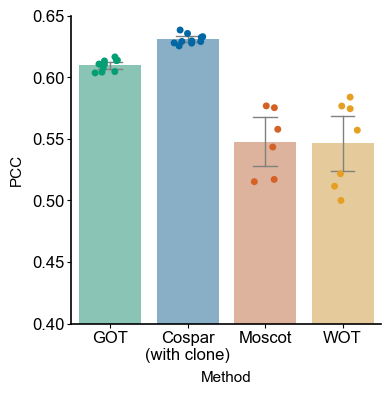

In [51]:


palette = {
    'GOT':'#049e74',
    'Cospar\n(with clone)':'#0066a4',
    'Moscot': '#d46126',
    'WOT':'#e5a023',
}

ax = sns.barplot(
    x='Method', y='PCC', data=pcc_df.loc[pcc_df['Method'].isin(['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'])], 
    
    capsize=.3,
    err_kws={"linewidth": 1., 'color':'grey'},
    palette=palette,
    order=['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'],
    #fill=False,
    legend=False,
    alpha=0.5
    
)

sns.stripplot(
    x='Method', y='PCC', data=pcc_df.loc[pcc_df['Method'].isin(['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'])], 
    
    dodge=False,  
    jitter=0.2,  
    palette=palette, 
    alpha=1.,
    legend=False,
    #ax=ax,
    size=5,
    order=['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT']
)
plt.ylim(0.4, 0.65)
plt.show()

In [52]:
#pcc_df.to_csv('./results/03_cellfate/hpsc_res.csv')

SCC: 0.6501301833687323
PCC: 0.6335552411387202
Mean Squared Error: 0.11769977355181098
R-squared: 0.40138153990056114
ROC-AUC: 0.843109607377783


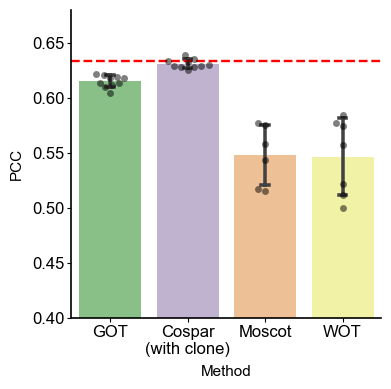

In [86]:
scc, pcc, mse, r2, auc = hf.positive_control(x0_adata, embedding_key, groundtruth_key)
pcc_df = pd.concat([pcc_df, pd.DataFrame([pcc, 'supervised LR'], index=['PCC', 'Method']).T])
sns.barplot(x='Method', y='PCC', data=pcc_df.loc[pcc_df['Method'].isin(['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'])], 
            capsize=.1, ci="sd", order=['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'], 
            palette='Accent')  # 使用 palette 设置不同颜色
sns.swarmplot(x='Method', y='PCC', data=pcc_df.loc[pcc_df['Method'].isin(['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'])], 
              color="black", alpha=.5, order=['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT']) 
plt.ylim(0.4, 0.68)
plt.axhline(y=pcc_df.loc[pcc_df['Method'] == 'supervised LR']['PCC'].tolist()[0], color='red', linestyle='--', label='supervised linear regression')
plt.show()
plt.close()

In [54]:
pcc_df.groupby('Method').apply(lambda x: x.PCC.mean())

Method
Cospar\n(with clone)    0.630709
GOT                     0.609761
Moscot                  0.547524
WOT                     0.546398
dtype: float64

## Visulization

In [55]:
show_idx = (x0_adata.obsm['X_spring'][:,1] > -2) & (x0_adata.obsm['X_spring'][:,0] < 3.5) & (x0_adata.obsm['X_spring'][:,0] > -2)

In [56]:
import matplotlib.colors as mcolors
fig, axes = plt.subplots(1, 5, figsize=(6.4*5, 4.8))

custom_cmap='coolwarm'

norm = mcolors.TwoSlopeNorm(vmin=0., vcenter=0.5, vmax=1.)


sc.pl.embedding(x0_adata[show_idx], color=groundtruth_key, ax=axes[0], basis='spring', cmap='coolwarm', colorbar_loc=None, frameon=False, title='', show=False)

print(hf.correlation_2x2(pred_bias_gots[np.array(gots_res)[:,1,0].argsort()[len(gots_res) // 2]], x0_adata, groundtruth_key, embedding_key))
sc.pl.embedding(x0_adata[show_idx], color='pred_fate_bias', ax=axes[1], basis='spring', cmap=custom_cmap, norm=norm, colorbar_loc=None, frameon=False, title='', show=False)

print(hf.correlation_2x2(pred_bias_cospars[np.array(cospar_res)[:,1,0].argsort()[len(cospar_res) // 2]], x0_adata, groundtruth_key, embedding_key))
sc.pl.embedding(x0_adata[show_idx], color='pred_fate_bias', ax=axes[2], basis='spring', cmap=custom_cmap, norm=norm, colorbar_loc=None, frameon=False, title='', show=False)

print(hf.correlation_2x2(pred_bias_moscot[np.array(moscot_res)[:,1,0].argsort()[len(moscot_res) // 2]], x0_adata, groundtruth_key, embedding_key))
sc.pl.embedding(x0_adata[show_idx], color='pred_fate_bias', ax=axes[3], basis='spring', cmap=custom_cmap, norm=norm, colorbar_loc=None, frameon=False, title='', show=False)

print(hf.correlation_2x2(pred_bias_wot[np.array(wot_res)[:,1,0].argsort()[len(wot_res) // 2]], x0_adata, groundtruth_key, embedding_key))
sc.pl.embedding(x0_adata[show_idx], color='pred_fate_bias', ax=axes[4], basis='spring', cmap=custom_cmap, norm=norm, colorbar_loc=None, frameon=False, title='', show=False)
#plt.show()



     pred vs gt  sm pred vs gt  pred vs sm gt  sm pred vs sm gt
scc    0.596377       0.599136       0.776062          0.789136
pcc    0.610635       0.611331       0.798443          0.807843
mse    0.149999       0.148354       0.067548          0.063826
r2    -0.136519      -0.177894       0.488199          0.493239
auc    0.818191       0.819810       0.904201          0.911142
     pred vs gt  sm pred vs gt  pred vs sm gt  sm pred vs sm gt
scc    0.627249       0.628358       0.805328          0.822375
pcc    0.629466       0.636174       0.817632          0.840997
mse    0.133576       0.127919       0.053090          0.043625
r2     0.124084       0.086754       0.651868          0.688548
auc    0.832661       0.833043       0.922091          0.931144
     pred vs gt  sm pred vs gt  pred vs sm gt  sm pred vs sm gt
scc    0.537255       0.560634       0.690486          0.737228
pcc    0.557708       0.582289       0.720809          0.766364
mse    0.191135       0.173582       0.1

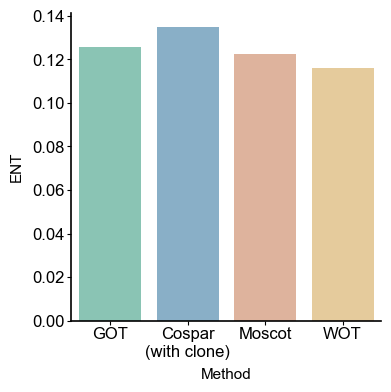

In [67]:
def ent(x):
    return -np.sum(np.log(x[(x>0.05)&(x<0.95)])*x[(x>0.05)&(x<0.95)]) / len(x)
    
ent_df =  pd.DataFrame([np.concatenate([
            [ent(x) for x in pred_bias_gots],
            [ent(x) for x in pred_bias_moscot],
            [ent(x) for x in pred_bias_cospars],
            [ent(x) for x in pred_bias_wot],
            
            ]), ['GOT']*len(gots_res)  + ["Moscot"]*len(moscot_res) + ["Cospar\n(with clone)"]*len(cospar_res) + ['WOT']*len(wot_res)  
                       # + ['OT-CFM']*len(wot_res) + ['MIOFlow']*len(mioflows_res) 
                       ], index=['ENT', 'Method']).T


palette = {
    'GOT':'#049e74',
    'Cospar\n(with clone)':'#0066a4',
    'Moscot': '#d46126',
    'WOT':'#e5a023',
}
#palette = 'Accent'

ax = sns.barplot(
    x='Method', y='ENT', data=ent_df.loc[ent_df['Method'].isin(['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'])], 
    
    capsize=.3,
    errorbar=None,
    err_kws={"linewidth": 1., 'color':'grey'},
    palette=palette,
    order=['GOT', 'Cospar\n(with clone)', 'Moscot', 'WOT'],
    #fill=False,
    legend=False,
    alpha=0.5
    
)




plt.show()

In [68]:
ent_df.to_csv('./results/03_cellfate/hpsc_ent.csv')